In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

In [ ]:
# Load in files
forwards_salary = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/salary/cap_all.csv')
forwards_rec = pd.read_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/NHL_points_projection/files/master_copies/forwards_rec.csv')

In [ ]:
# Clean up col names to match other csv fils
forwards_salary = forwards_salary.rename(columns={'CAP HIT': 'salary'})
forwards_salary = forwards_salary.drop(columns=['POS','HAND','AGE','G','A','SV%', 'TOTAL','TERM','TYPE'])
forwards_salary

,PLAYERS,TEAM,PTS,salary
0,"Matthews, Auston",TOR,56,"$13,250,000"
1,"MacKinnon, Nathan",COL,102,"$12,600,000"
2,"McDavid, Connor",EDM,85,"$12,500,000"
3,"Panarin, Artemi",NYR,69,"$11,642,857"
4,"Pettersson, Elias",VAN,39,"$11,600,000"
...,...,...,...,...
1045,"Buchinger, Michael",STL,0,"$838,333"
1046,"Mynio, Sawyer",VAN,0,"$838,333"
1047,"Krygier, Cole",LAK,0,"$837,500"
1048,"Caulfield, Judd",ANA,0,"$837,500"


In [4]:
# Define the bins and corresponding salary values
bins = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, float('inf')]
labels = [950000, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000]

# Use pd.cut to bin the values and map them to the salary values
forwards_rec['salary'] = pd.cut(forwards_rec['goals'], bins=bins, labels=labels, right=False)



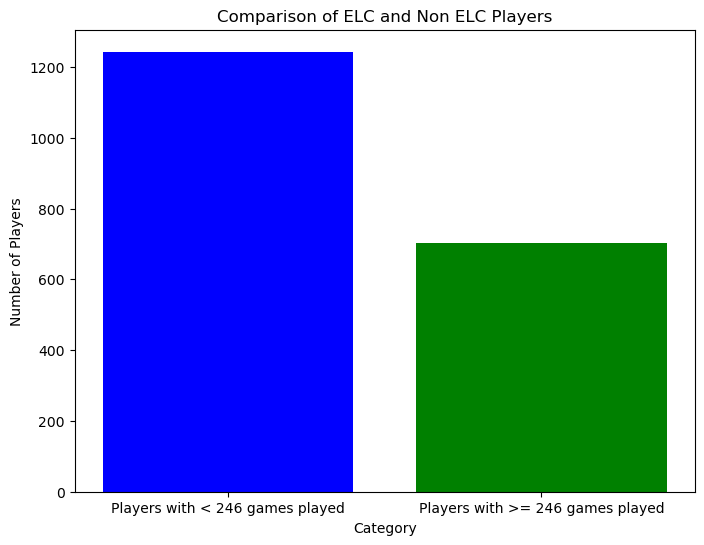

In [6]:
# Filter the DataFrame to count the number of players with fewer than 246 (elc) games played
games_played_threshold = 246
players_under_threshold = forwards_rec[forwards_rec['games_played'] < games_played_threshold]

# Count the number of players under the threshold
count_under_threshold = players_under_threshold.shape[0]

# Filter the df to count the number of players with over 246 (non elc)
players_over_threshold = forwards_rec[forwards_rec['games_played'] >= games_played_threshold]
count_over_threshold = players_over_threshold.shape[0]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Players with < 246 games played', 'Players with >= 246 games played'], [count_under_threshold, count_over_threshold], color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Number of Players')
plt.title('Comparison of ELC and Non ELC Players')
plt.show()

In [ ]:
# Create a df with all players still on Entry Level Deals
over_8000000 = forwards_rec[forwards_rec['games_played'] < 246]
over_8000000

,Unnamed: 0,name,d_zone_shift_starts,giveaways,goals,high_danger_goals,high_danger_shots,hits,low_danger_goals,low_danger_shots,...,games_played,icetime,on_ice_corsi_percentage,on_ice_fenwick_percentage,penalties_drawn,shots_blocked_by_player,assists,position_encoded,position,salary
0,0,A.J. Greer,1.243590,0.316239,0.081197,0.038462,0.158120,1.961538,0.034188,0.863248,...,234,534.529915,0.015513,0.015897,0.282051,0.371795,0.123932,1,F,2000000
1,1,Aaron Downey,0.000000,0.500000,0.250000,0.000000,0.000000,2.750000,0.000000,0.250000,...,4,312.500000,0.112500,0.120000,0.500000,0.250000,0.250000,1,F,6000000
2,3,Aaron Gagnon,1.500000,0.052632,0.078947,0.000000,0.078947,0.631579,0.026316,0.921053,...,38,502.894737,0.052632,0.052105,0.026316,0.368421,0.052632,1,F,2000000
3,7,Aaron Palushaj,1.220588,0.191176,0.044118,0.000000,0.044118,0.970588,0.029412,1.132353,...,68,542.294118,0.031324,0.030000,0.279412,0.367647,0.161765,1,F,950000
4,9,Aaron Volpatti,1.035088,0.096491,0.043860,0.017544,0.052632,2.254386,0.017544,0.640351,...,114,476.307018,0.020000,0.021404,0.219298,0.280702,0.017544,1,F,950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,2932,Zack Bolduc,1.060241,0.734940,0.204819,0.072289,0.144578,1.096386,0.060241,1.759036,...,83,739.698795,0.011928,0.012169,0.156627,0.506024,0.216867,1,F,6000000
1940,2934,Zack MacEwen,1.333333,0.253165,0.071730,0.008439,0.097046,2.202532,0.029536,1.063291,...,237,560.012658,0.014135,0.014051,0.282700,0.379747,0.071730,1,F,2000000
1941,2935,Zack Mitchell,0.823529,0.029412,0.088235,0.058824,0.147059,1.176471,0.000000,0.647059,...,34,591.323529,0.022647,0.022647,0.058824,0.382353,0.058824,1,F,2000000
1942,2936,Zack Ostapchuk,0.901961,0.274510,0.019608,0.000000,0.058824,1.960784,0.019608,0.627451,...,51,567.745098,0.016667,0.015882,0.215686,0.352941,0.058824,1,F,950000


In [28]:
# Define the over_8000000 DataFrame based on the criteria
over_8000000 = forwards_rec[forwards_rec['games_played'] < 246]

# Change the salary of all players in the over_8000000 DataFrame to $950,000 in the forwards_rec DataFrame
forwards_rec.loc[over_8000000.index, 'salary'] = 950000

In [ ]:
# Save the file to csv
forwards_rec.to_csv('/Users/blairjdaniel/lighthouse/lighthouse/NHL/files/master_copies/forwards_rec_two.csv')